# Overview

This notebook presents several classifiers aiming to predict startups success (aquired or failed, no IPO data in the imput dataset) based on the avaliable data.
 For the input data analysis, please view EDA notebood in the same repository.
 The dataset can be found here: https://www.kaggle.com/datasets/manishkc06/startup-success-prediction/data

 # Take code from git

In [1]:
# !rm -r Applied_DS_Project # pay attention!
# !git clone https://github.com/MayaVB/Applied_DS_Project.git

In [2]:
# !ls Applied_DS_Project

In [3]:
# !ls Applied_DS_Project/src

# Install requirements

In [4]:
# !pip install -r Applied_DS_Project/requirements.txt

In [5]:
# consider for future features
# %pip install yfinance
# %pip install tweepy
# %pip install wbdata pandas
# %pip install xgboost

# Imports

In [6]:
# set working directory:
# %cd Applied_DS_Project/src

# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from eval import plot_feature_importances, plot_auc_roc_curve, perform_cross_validation
from getdata import add_nasdaq_annual_changes, add_economic_indicators
from models import train_xgb_model, train_rf_model, train_svm_model, train_decision_tree_model
from models import train_rfv2_model, evaluate_model, predict_model
from printstatistics import print_correlations_Spearman_and_Pearson
from preprocess import preprocess_data, preprocess_data_classifier
from utils import set_seed, load_data
from regression_models import train_and_evaluate_r
from eval import get_ratio, cross_validation_generator

# Load Data

In [7]:
df = load_data('../data/startup_data.csv')

# Convert the date column to datetime
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'])

# Extract year, month, and day into separate columns
df['first_funding_at_year'] = df['first_funding_at'].dt.year
df['first_funding_at_month'] = df['first_funding_at'].dt.month
df['first_funding_at_day'] = df['first_funding_at'].dt.day

# Convert the date column to datetime
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'])

# Extract year, month, and day into separate columns
df['first_funding_at_year'] = df['last_funding_at'].dt.year
df['first_funding_at_month'] = df['last_funding_at'].dt.month
df['first_funding_at_day'] = df['last_funding_at'].dt.day


df = df.drop(columns=['first_funding_at', 'last_funding_at', 'state_code.1'])
#in this dataset state_code is safe to drop as the vast majority of the starttups in this dataset are in locations with high VC activity

In [8]:
# # Create label
# df['status_code'] = df['status'].map({'acquired': 1, 'closed': 0})

# print_correlations_Spearman_and_Pearson(df['relationships'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['avg_participants'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundC'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundD'], df['status_code'])

# print_correlations_Spearman_and_Pearson(df['relationships'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['avg_participants'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundC'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundD'], df['status_code'])

# df.drop(columns=['status_code'])

# Visualize geograpy

See more visualizations in the EDA notebook

In [9]:
import folium

latitude_initial = 39.8283
longitude_initial = -50.0000

map = folium.Map(location = [latitude_initial, longitude_initial], zoom_start = 3, tiles = 'cartodbpositron')

for index, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup = row['state_code']).add_to(map)

map

# Preprocess Data

## try

In [10]:
'''
std_deviation = 2
mean = df['avg_participants'].mean()
std = df['avg_participants'].std()

upper_threshold = mean + (std_deviation * std)
lower_threshold = mean - (std_deviation * std)
df = df[(df['avg_participants'] >= lower_threshold) & (df['avg_participants'] <= upper_threshold)]
len(df)
'''

"\nstd_deviation = 2\nmean = df['avg_participants'].mean()\nstd = df['avg_participants'].std()\n\nupper_threshold = mean + (std_deviation * std)\nlower_threshold = mean - (std_deviation * std)\ndf = df[(df['avg_participants'] >= lower_threshold) & (df['avg_participants'] <= upper_threshold)]\nlen(df)\n"

## run

In [11]:
# Add economic indicators
df = add_nasdaq_annual_changes(df)
indicator_code = 'NY.GDP.MKTP.KD.ZG'
df = add_economic_indicators(df, indicator_code)
indicator_code = 'SL.UEM.TOTL.ZS'
df = add_economic_indicators(df, indicator_code)

random_state = 42
set_seed(random_state)

# Preprocess the data
X, y = preprocess_data_classifier(df, useKNNImputer=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

[*********************100%%**********************]  1 of 1 completed
/home/mayavb/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
print(len(y_train))
print(len(y_test))

738
185


In [13]:
# Calculate the ratio of negative class to positive class
train_ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
print(round(train_ratio, 2))
test_ratio = float(y_test.value_counts()[0]) / y_test.value_counts()[1]
round(test_ratio, 2)

0.55


0.54

# Train predict and evaluate classifiers

## XG Boost

### cross-validation with stratified sampling

In [14]:
fold = 5
metrics_val = { 'Accuracy': [], 'AUC-ROC': [], 'Balanced Accuracy': [], 'Precision': [], 'Recall': [] }  # Replace with your metrics

#np.zeros(fold)
for i, (train_index, test_index) in enumerate(cross_validation_generator(X, y, fold)):
  print(f"Fold {i}, ratio {round(get_ratio(y[train_index]), 2)}:")
  xgb_clf = train_xgb_model(X.iloc[train_index] ,  y[train_index])
  xgb_pred, xgb_prob = predict_model(xgb_clf, X.iloc[test_index])
  fold_metrics = evaluate_model(y[test_index], xgb_pred, xgb_prob, threshold=0.5)
  
  # Store metric for averaging
  for metric_name, value in fold_metrics.items():
      metrics_val[metric_name].append(value)
  
  print()  # plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
  # plot_auc_roc_curve(y[test_index], xgb_prob, model_name='XG-Boost')
  

Fold 0, ratio 0.55:
Threshold: 0.5
AUC-ROC: 0.77
Accuracy: 0.74
Balanced Accuracy: 0.68
Precision (Test): 0.762962962962963
Recall (Test): 0.8583333333333333

Fold 1, ratio 0.55:
Threshold: 0.5
AUC-ROC: 0.84
Accuracy: 0.8
Balanced Accuracy: 0.77
Precision (Test): 0.8267716535433071
Recall (Test): 0.875

Fold 2, ratio 0.54:
Threshold: 0.5
AUC-ROC: 0.76
Accuracy: 0.76
Balanced Accuracy: 0.71
Precision (Test): 0.7803030303030303
Recall (Test): 0.865546218487395

Fold 3, ratio 0.55:
Threshold: 0.5
AUC-ROC: 0.85
Accuracy: 0.83
Balanced Accuracy: 0.79
Precision (Test): 0.8372093023255814
Recall (Test): 0.907563025210084

Fold 4, ratio 0.55:
Threshold: 0.5
AUC-ROC: 0.82
Accuracy: 0.76
Balanced Accuracy: 0.72
Precision (Test): 0.7952755905511811
Recall (Test): 0.8487394957983193



In [15]:
# Compute average and standard deviation for metrics across folds
average_metrics = {metric: np.mean(values) for metric, values in metrics_val.items()}
std_dev_metrics = {metric: np.std(values) for metric, values in metrics_val.items()}

# Print results
print("Average Metrics Across Folds:")
for metric, average in average_metrics.items():
    print(f"{metric}: {average:.4f}")

print("\nStandard Deviation of Metrics Across Folds:")
for metric, std_dev in std_dev_metrics.items():
    print(f"{metric}: {std_dev:.4f}")

Average Metrics Across Folds:
Accuracy: 0.7758
AUC-ROC: 0.8084
Balanced Accuracy: 0.7362
Precision: 0.8005
Recall: 0.8710

Standard Deviation of Metrics Across Folds:
Accuracy: 0.0327
AUC-ROC: 0.0364
Balanced Accuracy: 0.0392
Precision: 0.0279
Recall: 0.0202


### single split

In [16]:
metrics = {}

Threshold: 0.5
AUC-ROC: 0.84
Accuracy: 0.79
Balanced Accuracy: 0.77
Precision (Test): 0.8360655737704918
Recall (Test): 0.85
Cross-Validation Accuracy Scores: [0.72297297 0.79054054 0.78378378 0.76190476 0.75510204]
Mean Cross-Validation Accuracy: 0.76
Cross-Validation Balanced Accuracy Scores: [0.69391026 0.75480769 0.74816286 0.72004049 0.70172065]
Mean Cross-Validation Balanced Accuracy: 0.72
Cross-Validation AUC Scores: [0.75641026 0.8369391  0.8387289  0.82530364 0.7597166 ]
Mean Cross-Validation AUC: 0.8
Cross-Validation Precision Scores: [0.78350515 0.81553398 0.80582524 0.78846154 0.7706422 ]
Mean Cross-Validation Precision: 0.79
Cross-Validation Recall Scores: [0.79166667 0.875      0.87368421 0.86315789 0.88421053]
Mean Cross-Validation Recall: 0.86
Cross-Validation F1 Scores: [0.78756477 0.84422111 0.83838384 0.8241206  0.82352941]
Mean Cross-Validation F1: 0.82
Cross-Validation Kappa Scores: [0.38953722 0.52583712 0.51345798 0.4580217  0.42961845]
Mean Cross-Validation Kapp

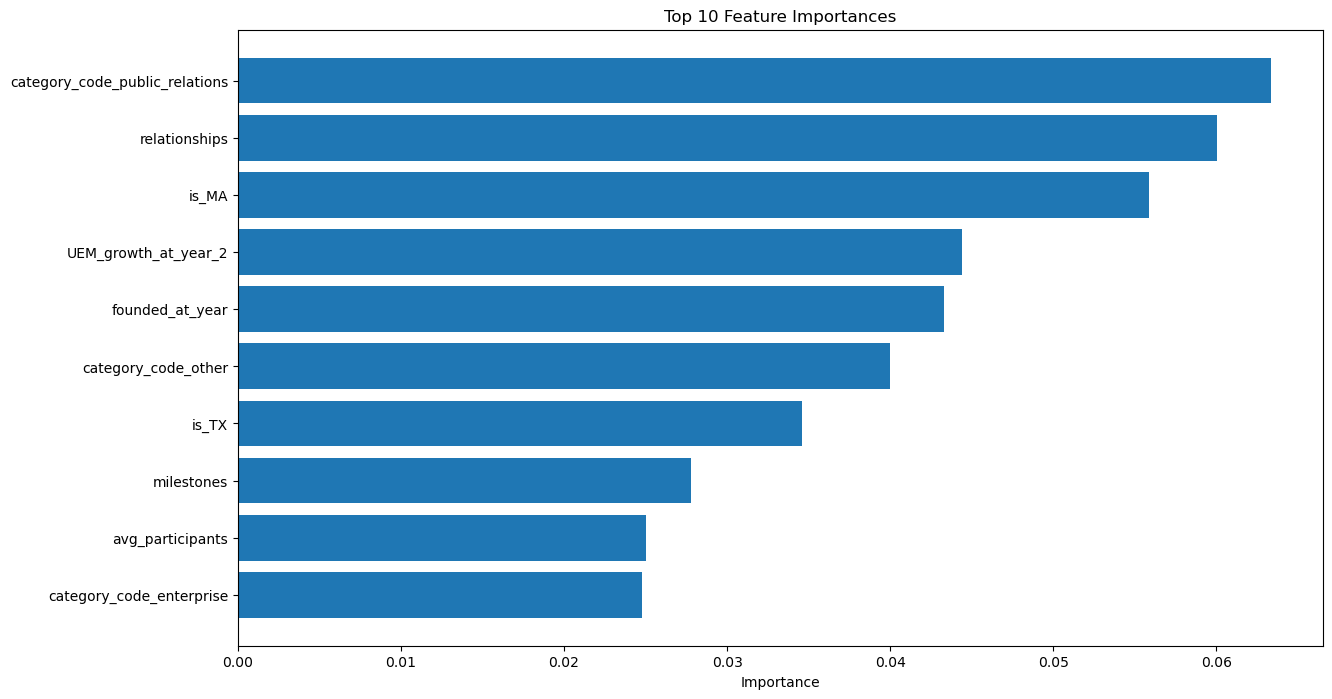

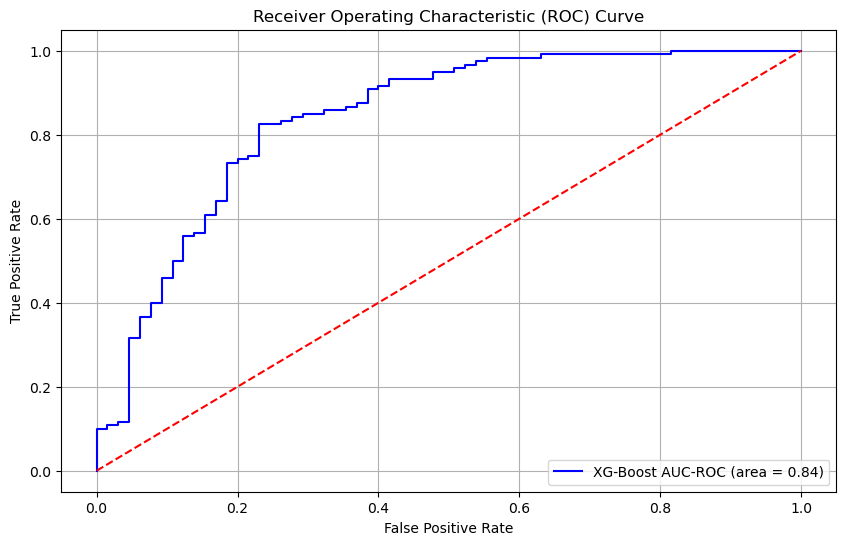

In [17]:
xgb_clf = train_xgb_model(X_train, y_train)
xgb_pred, xgb_prob = predict_model(xgb_clf, X_test)
metrics['XGBoost'] = evaluate_model(y_test, xgb_pred, xgb_prob, threshold=0.5)

cv_results_xgb = perform_cross_validation(xgb_clf, X_train, y_train, n_splits=5, random_state=random_state)
metrics['XGBoost']['Kappa'] = round(cv_results_xgb['test_kappa'].mean(), 2)


plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, xgb_prob, model_name='XG-Boost')

## Random Forest Ver2

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Threshold: 0.7
AUC-ROC: 0.85
Accuracy: 0.76
Balanced Accuracy: 0.74
Precision (Test): 0.8220338983050848
Recall (Test): 0.8083333333333333
Cross-Validation Accuracy Scores: [0.72972973 0.78378378 0.81756757 0.73469388 0.76190476]
Mean Cross-Validation Accuracy: 0.77
Cross-Validation Balanced Accuracy Scores: [0.69471154 0.74959936 0.78282026 0.6902834  0.70263158]
Mean Cross-Validation Balanced Accuracy: 0.72
Cross-Validation AUC Scores: [0.77083333 0.86478365 0.86554121 0.82246964 0.78076923]
Mean Cross-Validation AUC: 0.82
Cross-Validation Precision Scores: [0.78       0.81372549 0.82692308 0.76923077 0.76785714]
Mean Cross-Validation Precision: 0.79
Cross-Validation Recall Scores: [0.8125     0.86458333 0.90526316 0.84210526 0.90526316]
Mean Cross-Validation Recall: 0.87
Cross-Validation F1 Scores: [0.79591837 0.83838384 0.86432161 0.8040201  0.83091787]
Mean Cross-Validation F1: 0.83
Cross-Validation Kappa Scores: [0.396

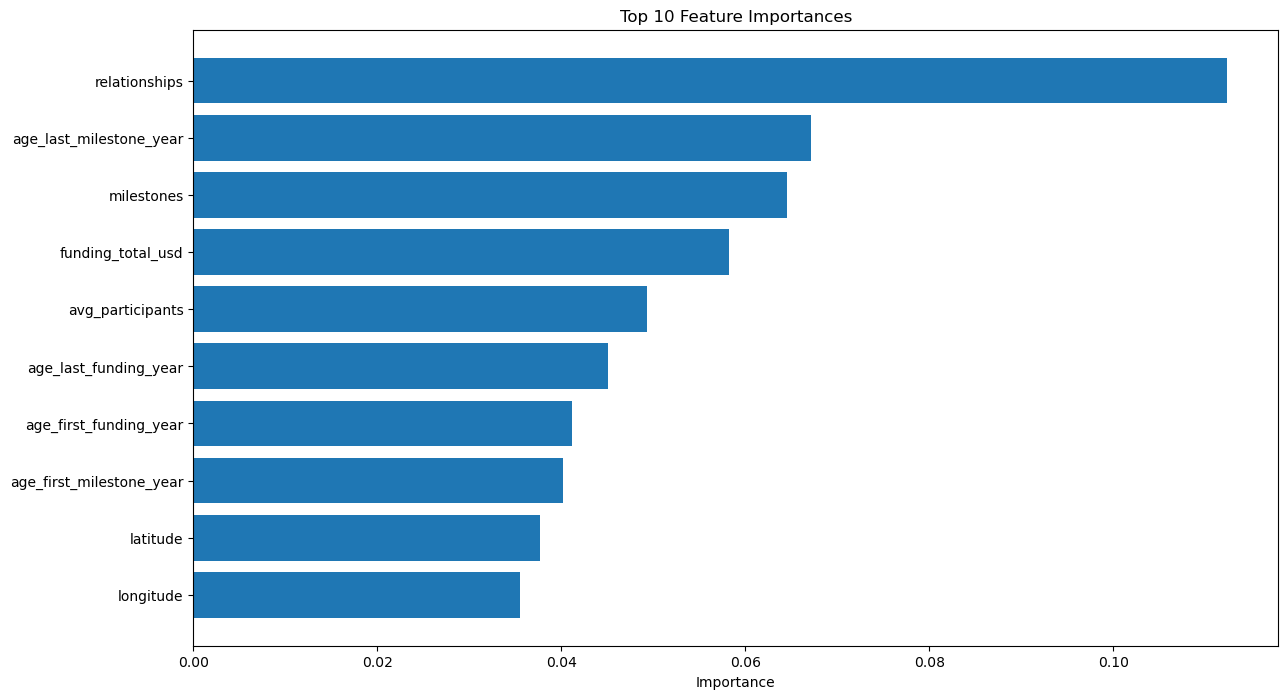

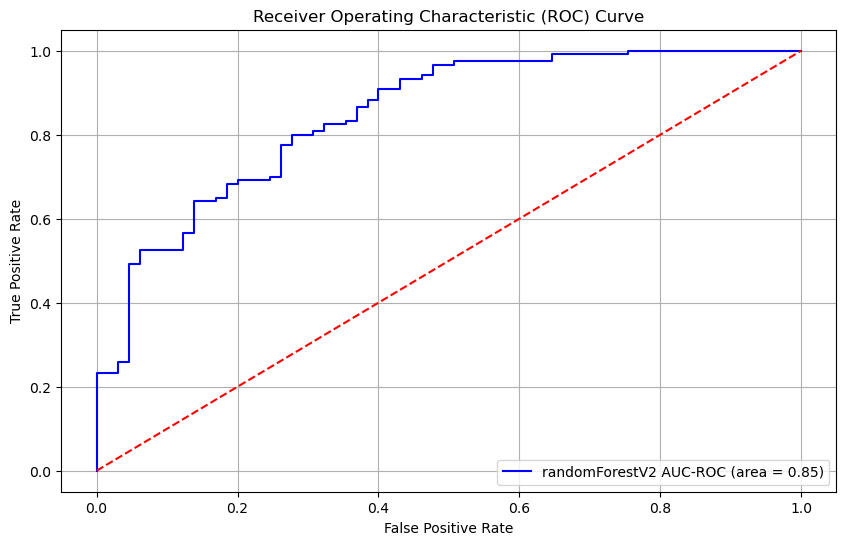

In [18]:
rfv2_clf = train_rfv2_model(X_train, y_train)
rfv2_pred, rfv2_prob = predict_model(rfv2_clf, X_test)
metrics['RandomForestV2'] = evaluate_model(y_test, rfv2_pred, rfv2_prob)

cv_results_rfv2 = perform_cross_validation(rfv2_clf, X_train, y_train, n_splits=5, random_state=random_state)
metrics['RandomForestV2']['Kappa'] = round(cv_results_rfv2['test_kappa'].mean(), 2)

plot_feature_importances(rfv2_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, rfv2_prob, model_name='randomForestV2')

## Fandom Forest

Threshold: 0.7
AUC-ROC: 0.85
Accuracy: 0.79
Balanced Accuracy: 0.76
Precision (Test): 0.8292682926829268
Recall (Test): 0.85
Cross-Validation Accuracy Scores: [0.75       0.78378378 0.7972973  0.76190476 0.76870748]
Mean Cross-Validation Accuracy: 0.77
Cross-Validation Balanced Accuracy Scores: [0.70592949 0.74959936 0.75034757 0.71133603 0.70789474]
Mean Cross-Validation Balanced Accuracy: 0.73
Cross-Validation AUC Scores: [0.76051683 0.87329728 0.86444886 0.81953441 0.76953441]
Mean Cross-Validation AUC: 0.82
Cross-Validation Precision Scores: [0.78095238 0.81372549 0.79816514 0.77777778 0.7699115 ]
Mean Cross-Validation Precision: 0.79
Cross-Validation Recall Scores: [0.85416667 0.86458333 0.91578947 0.88421053 0.91578947]
Mean Cross-Validation Recall: 0.89
Cross-Validation F1 Scores: [0.8159204  0.83838384 0.85294118 0.82758621 0.83653846]
Mean Cross-Validation F1: 0.83
Cross-Validation Kappa Scores: [0.42886942 0.5127572  0.53174436 0.4480206  0.45113112]
Mean Cross-Validation Kap

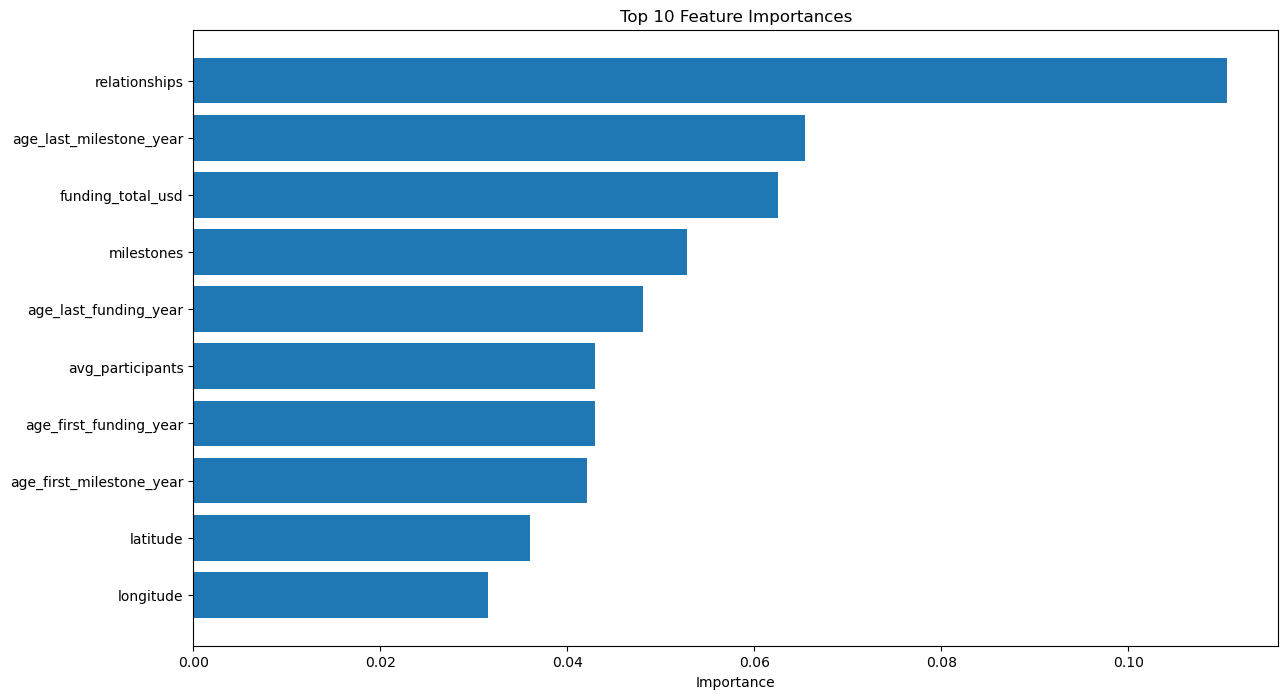

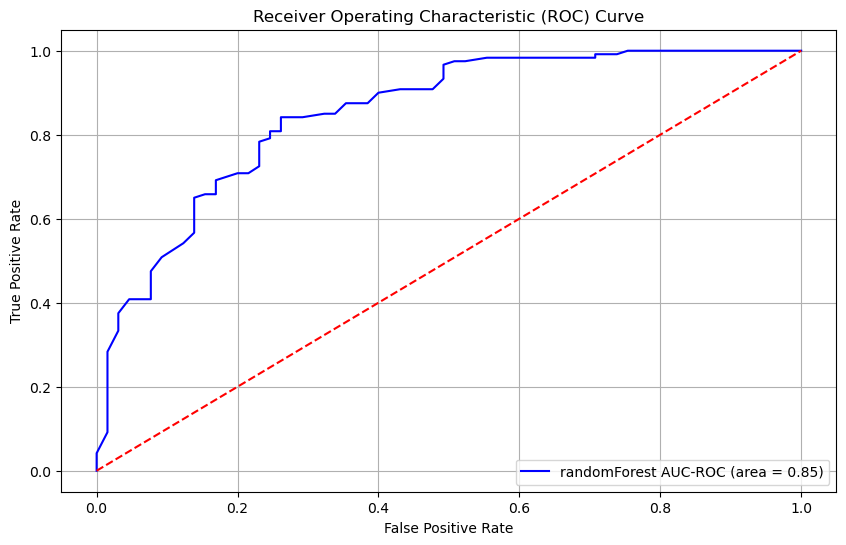

In [19]:
rf_clf = train_rf_model(X_train, y_train)
rf_pred, rf_prob = predict_model(rf_clf, X_test)
metrics['RandomForest'] = evaluate_model(y_test, rf_pred, rf_prob)

cv_results_rf = perform_cross_validation(rf_clf, X_train, y_train, n_splits=5, random_state=random_state)
metrics['RandomForest']['Kappa'] = round(cv_results_rf['test_kappa'].mean(), 2)

plot_feature_importances(rf_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, rf_prob, model_name='randomForest')

## SVM

Threshold: 0.7
AUC-ROC: 0.8
Accuracy: 0.77
Balanced Accuracy: 0.72
Precision (Test): 0.7851851851851852
Recall (Test): 0.8833333333333333
Cross-Validation Accuracy Scores: [0.71621622 0.79054054 0.77027027 0.72789116 0.76870748]
Mean Cross-Validation Accuracy: 0.75
Cross-Validation Balanced Accuracy Scores: [0.67548077 0.74158654 0.7000993  0.65455466 0.70789474]
Mean Cross-Validation Balanced Accuracy: 0.7
Cross-Validation AUC Scores: [0.73317308 0.82331731 0.85600794 0.80222672 0.77489879]
Mean Cross-Validation AUC: 0.8
Cross-Validation Precision Scores: [0.76470588 0.79816514 0.75630252 0.73504274 0.7699115 ]
Mean Cross-Validation Precision: 0.76
Cross-Validation Recall Scores: [0.8125     0.90625    0.94736842 0.90526316 0.91578947]
Mean Cross-Validation Recall: 0.9
Cross-Validation F1 Scores: [0.78787879 0.84878049 0.8411215  0.81132075 0.83653846]
Mean Cross-Validation F1: 0.83
Cross-Validation Kappa Scores: [0.36049383 0.51253719 0.44471419 0.34184016 0.45113112]
Mean Cross-Vali

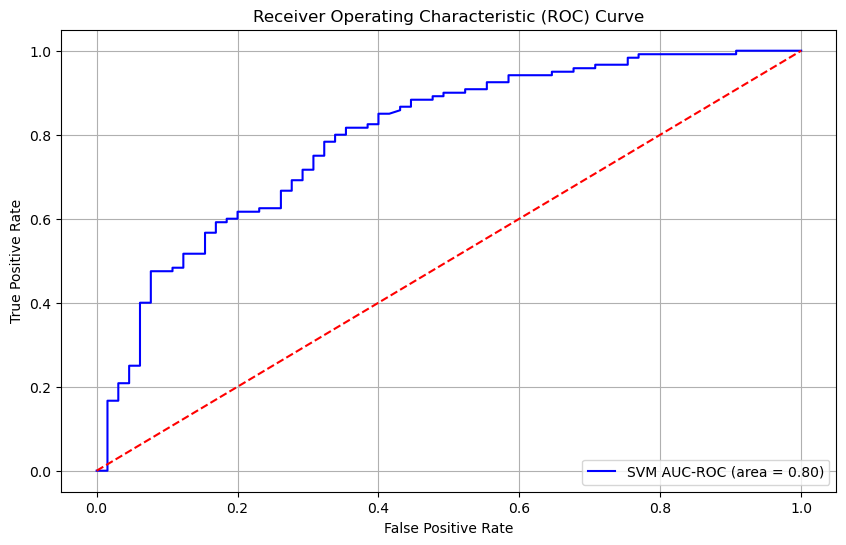

In [20]:
svm_clf = train_svm_model(X_train, y_train)
svm_pred, svm_prob = predict_model(svm_clf, X_test)
metrics['SVM'] = evaluate_model(y_test, svm_pred, svm_prob)

cv_results_SVM = perform_cross_validation(svm_clf, X_train, y_train, n_splits=5, random_state=random_state)
metrics['SVM']['Kappa'] = round(cv_results_SVM['test_kappa'].mean(), 2)

plot_auc_roc_curve(y_test, svm_prob, model_name='SVM')

# Ensemble classifiers

## Ensemble with SVM

Threshold: 0.5
AUC-ROC: 0.85
Accuracy: 0.78
Balanced Accuracy: 0.75
Precision (Test): 0.8174603174603174
Recall (Test): 0.8583333333333333


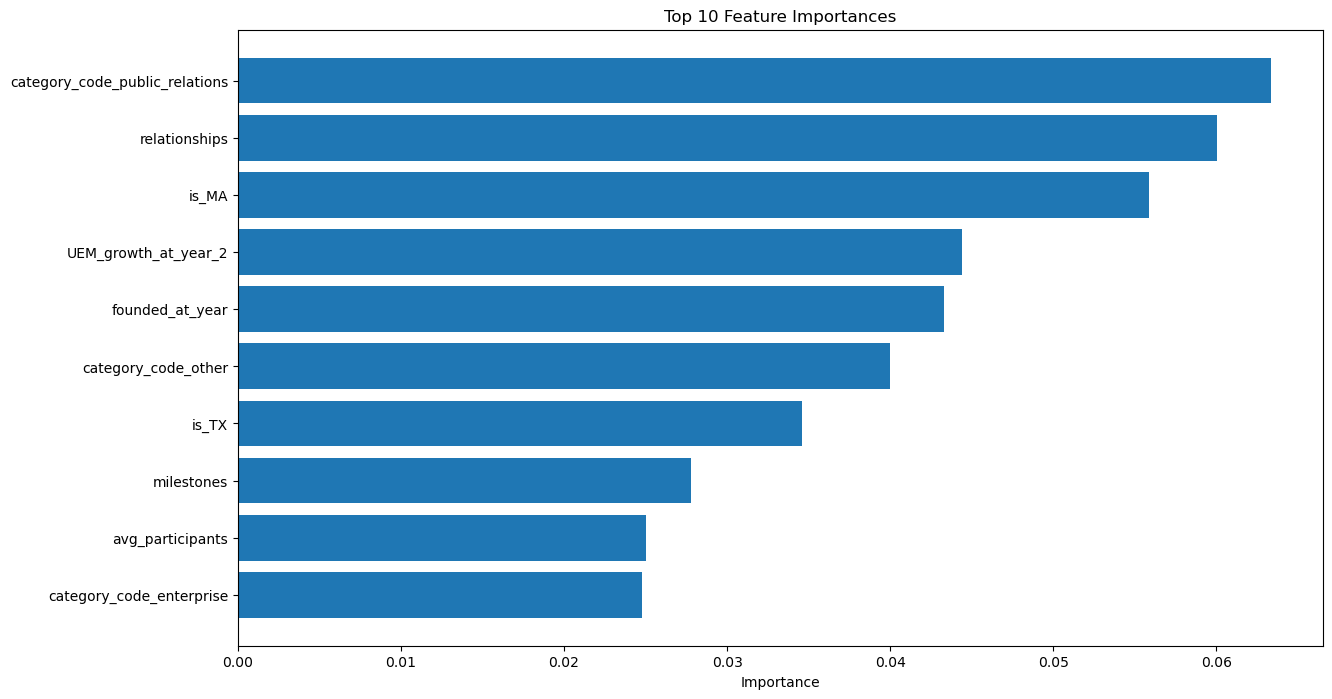

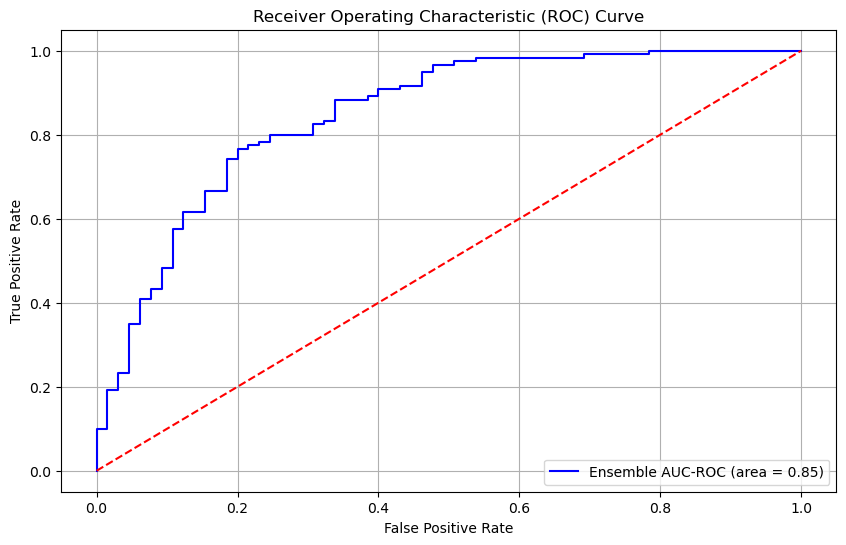

In [21]:
# Combine predictions using majority voting

# Stack the predictions into a matrix
predictions = np.vstack((xgb_pred, rfv2_pred, svm_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rfv2_prob + svm_prob) / 3

# Evaluate the ensemble model
evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

## Ensemble without SVM

Threshold: 0.5
AUC-ROC: 0.86
Accuracy: 0.77
Balanced Accuracy: 0.74
Precision (Test): 0.8145161290322581
Recall (Test): 0.8416666666666667


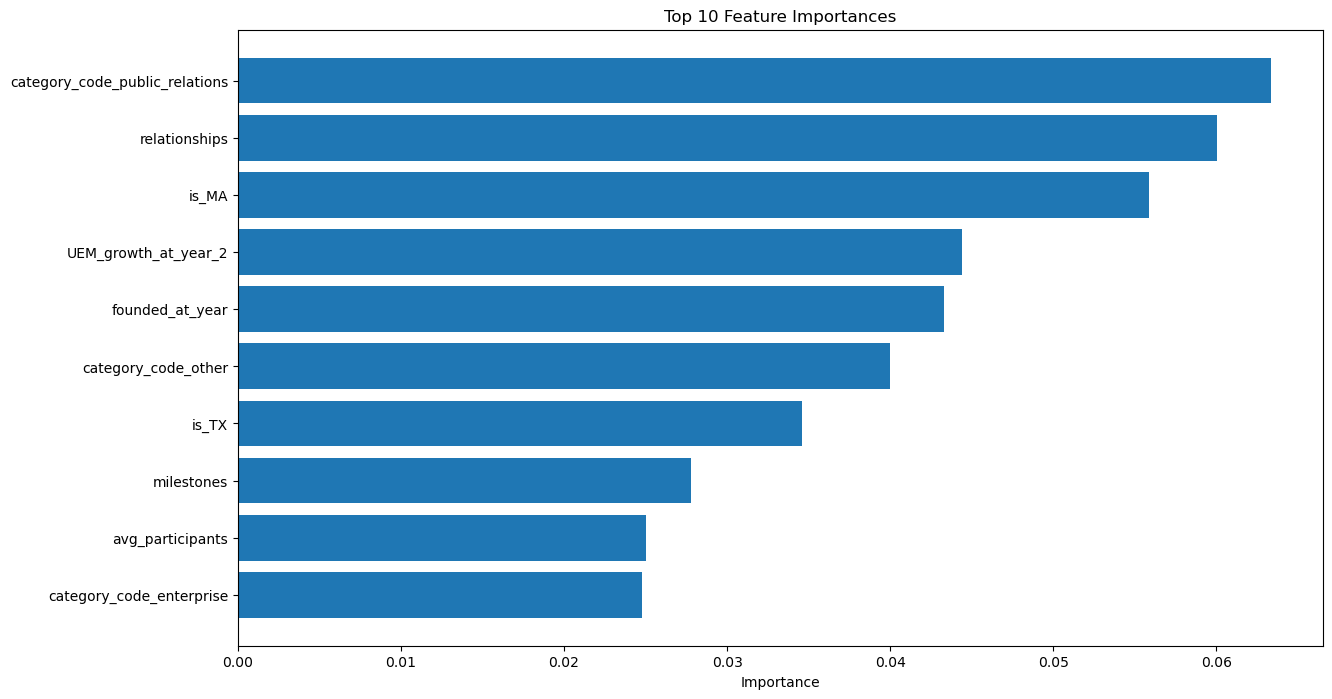

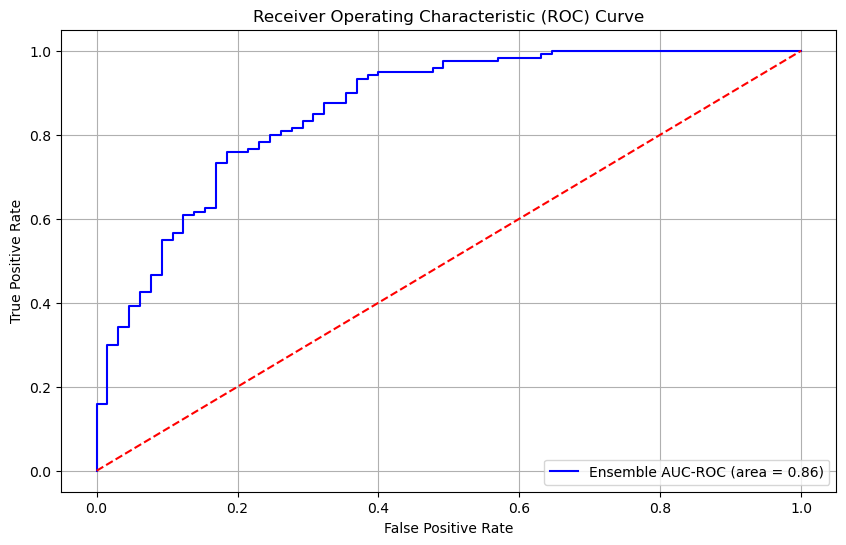

In [22]:
# Combine predictions using majority voting

# Stack the predictions into a matrix
predictions = np.vstack((xgb_pred, rfv2_pred, rf_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rfv2_prob + rf_prob) / 3

# Evaluate the ensemble model
evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

## Ensemble all

Threshold: 0.5
AUC-ROC: 0.85
Accuracy: 0.77
Balanced Accuracy: 0.75
Precision (Test): 0.819672131147541
Recall (Test): 0.8333333333333334


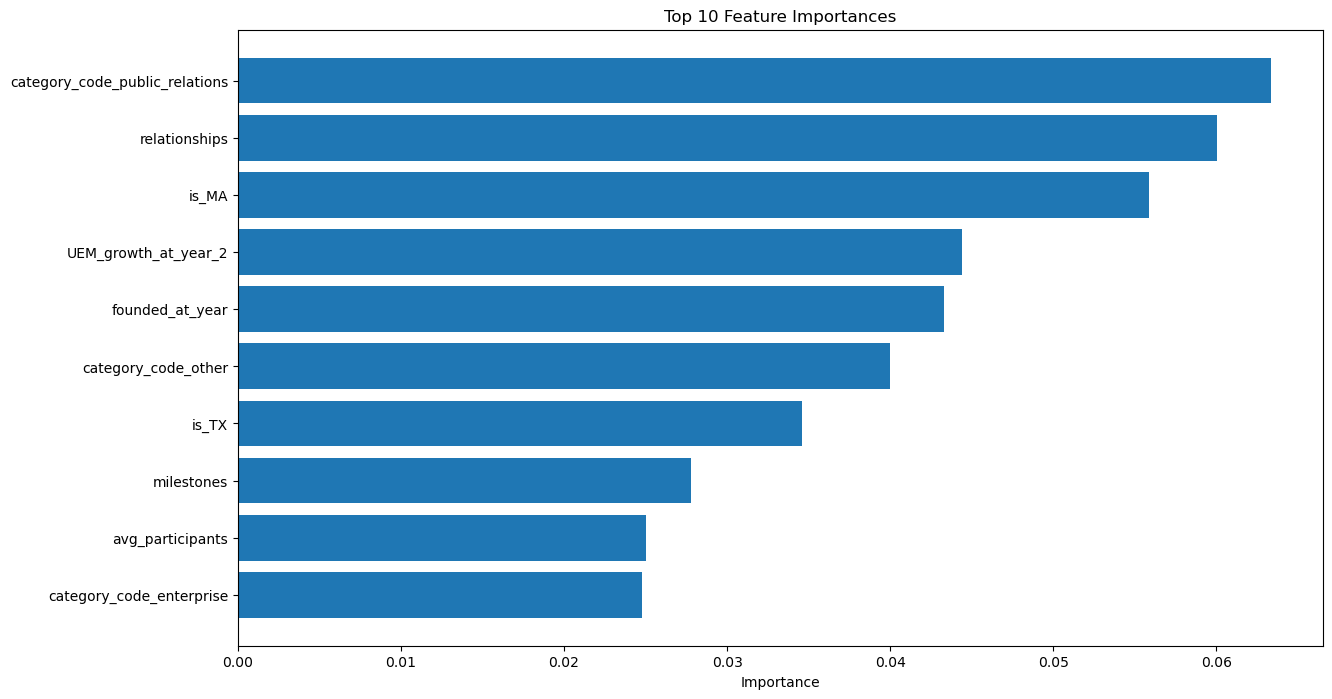

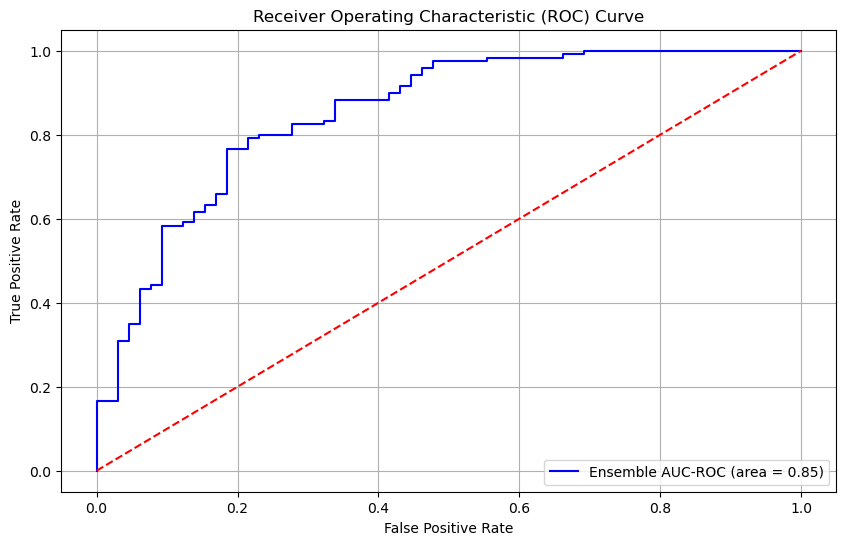

In [23]:
# Combine predictions using majority voting

# Stack the predictions into a matrix
predictions = np.vstack((xgb_pred, rfv2_pred, rf_pred, svm_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rfv2_prob + rf_prob + svm_prob) / 4

# Evaluate the ensemble model
metrics['Ensemble'] = evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

# Analyse classifier results

plot all models results graph

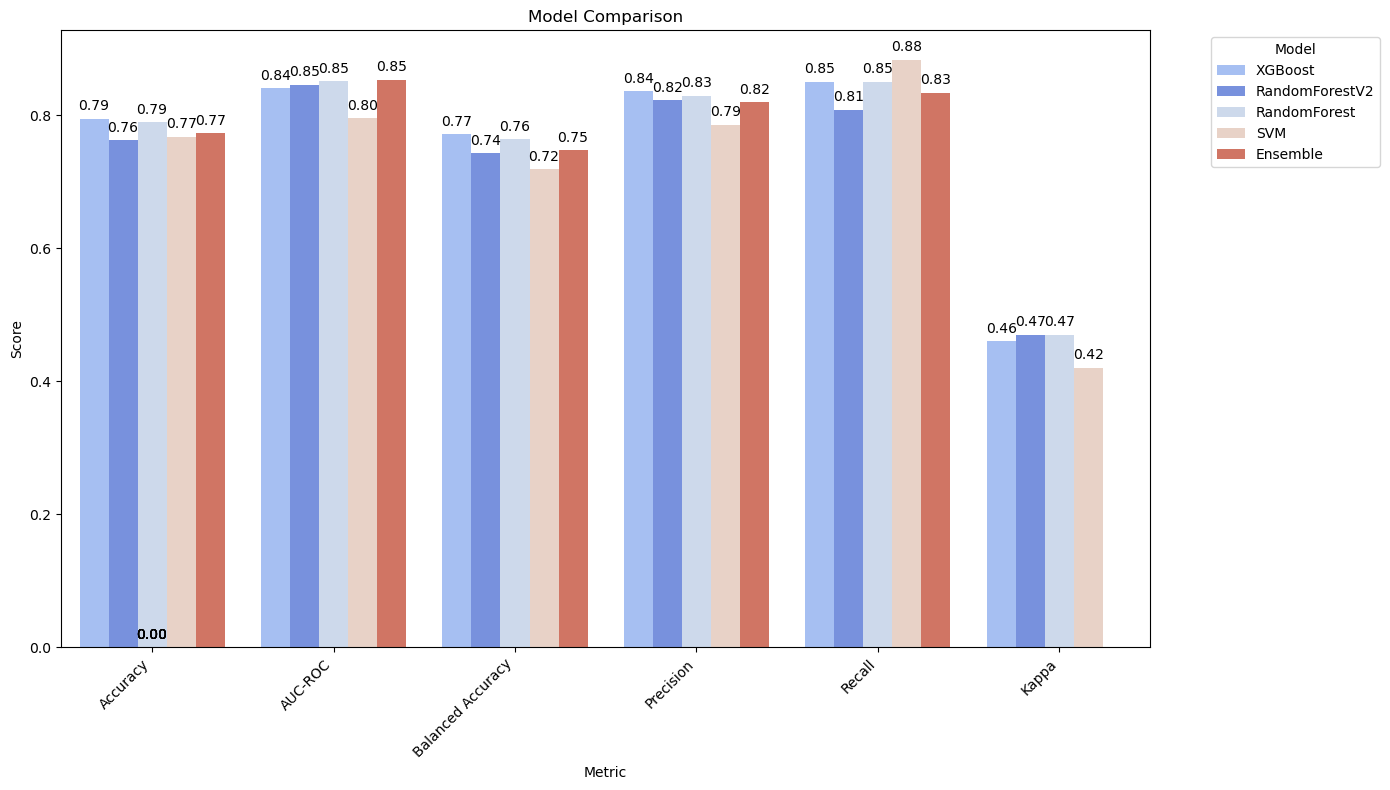

In [24]:
# Define the models and use Seaborn's pastel palette
models = ['RandomForestV2', 'XGBoost', 'RandomForest', 'SVM', 'DecisionTree', 'Ensemble']
colors = sns.color_palette('coolwarm', n_colors=len(models))

# Create a dictionary to map the model names to the pastel colors
color_mapping = dict(zip(models, colors))

# Convert metrics to DataFrame for plotting
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
metrics_df.columns = ['Model', 'Metric', 'Score']

plt.figure(figsize=(14, 8))

# Use seaborn to create the bar plot with the pastel colors
ax = sns.barplot(
    x='Metric', 
    y='Score', 
    hue='Model', 
    data=metrics_df, 
    palette=color_mapping
)

# Add the numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Model Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Combine with the original features

In [25]:
import pandas as pd

# Create DataFrame with all features, y_test, and predictions
result_df = pd.DataFrame(X_test, columns=X.columns)
result_df['Actual'] = y_test.values
'''
result_df['Predicted_xgb'] = xgb_pred
result_df['Probability_xgb'] = xgb_prob
result_df['Predicted_rfv2'] = rfv2_pred
result_df['Probability_rfv2'] = rfv2_prob
result_df['Predicted_rf'] = rf_pred
result_df['Probability_rf'] = rf_prob
result_df['Predicted_svm'] = svm_pred
result_df['Probability_svm'] = svm_prob
'''
result_df['Predicted_ensemble'] = ensemble_pred
result_df['Probability_ensemble'] = ensemble_prob

# Display the DataFrame
result_df.head()

,category_code_advertising,category_code_analytics,category_code_automotive,category_code_biotech,category_code_cleantech,category_code_consulting,category_code_ecommerce,category_code_education,category_code_enterprise,category_code_fashion,...,UEM_growth_at_year_4,UEM_growth_at_year_5,UEM_growth_at_year_6,UEM_growth_at_year_7,UEM_growth_at_year_8,UEM_growth_at_year_9,UEM_growth_at_year_10,Actual,Predicted_ensemble,Probability_ensemble
739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.604288,1.310711,0.893472,-0.504855,-1.289024,-1.124692,-0.892687,1,1,0.860056
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.698255,-0.002970,0.558446,0.922449,0.513016,-0.612743,-1.396864,1,1,0.714864
592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.156248,0.529761,0.718045,1.069944,1.636902,2.155986,1.330940,1,1,0.802436
237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.035482,0.642984,1.165186,0.688725,-0.545468,-1.351670,-1.176347,0,0,0.258031
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.698255,-0.002970,0.558446,0.922449,0.513016,-0.612743,-1.396864,1,1,0.809858


## try - drafts

In [26]:
df1 = load_data('../data/startup_data.csv')

In [27]:
result_df_ok = result_df[result_df['Predicted_ensemble'] == result_df['Actual']]
result_df_fail = result_df[result_df['Predicted_ensemble'] != result_df['Actual']]

print(result_df_ok['category_code_biotech'].value_counts() / len(result_df_ok))

category_code_biotech
0.0    0.972028
1.0    0.027972
Name: count, dtype: float64


In [28]:
# Correlation analysis for incorrect predictions, to see which features correlate with the errors, focusing on predicted values
incorrect_corr = abs(result_df_fail.corr())
print("Correlation in Incorrect Predictions with Predicted Values:\n", incorrect_corr['Predicted_ensemble'].sort_values(ascending=False).head(15))


Correlation in Incorrect Predictions with Predicted Values:
 Predicted_ensemble      1.000000
Actual                  1.000000
Probability_ensemble    0.771341
UEM_growth_at_year_1    0.422925
GDP_growth_at_year_3    0.411644
UEM_growth_at_year_2    0.410883
GDP_growth_at_year_2    0.385857
has_roundB              0.298481
first_funding_at_day    0.297277
GDP_growth_at_year_7    0.273764
GDP_growth_at_year_9    0.260340
milestones              0.254041
is_top500               0.250511
founded_at_year         0.249527
UEM_growth_at_year_0    0.247045
Name: Predicted_ensemble, dtype: float64


In [29]:
# Add a new column 'predicted_correctly' to the DataFrame
result_df['predicted_correctly'] = (result_df['Predicted_ensemble'] == result_df['Actual']).astype(int)


                  Total  Correct  Incorrect  Accuracy
web                35.0     27.0        8.0  0.771429
software           28.0     24.0        4.0  0.857143
enterprise         12.0      9.0        3.0  0.750000
advertising        12.0     12.0        0.0  1.000000
mobile             10.0      6.0        4.0  0.600000
games_video        10.0      9.0        1.0  0.900000
network_hosting    10.0      6.0        4.0  0.600000
hardware            7.0      5.0        2.0  0.714286
public_relations    7.0      7.0        0.0  1.000000
cleantech           6.0      4.0        2.0  0.666667
biotech             6.0      4.0        2.0  0.666667
semiconductor       6.0      5.0        1.0  0.833333
security            6.0      5.0        1.0  0.833333
ecommerce           4.0      3.0        1.0  0.750000
travel              3.0      2.0        1.0  0.666667
social              2.0      1.0        1.0  0.500000
other               2.0      1.0        1.0  0.500000
messaging           2.0     

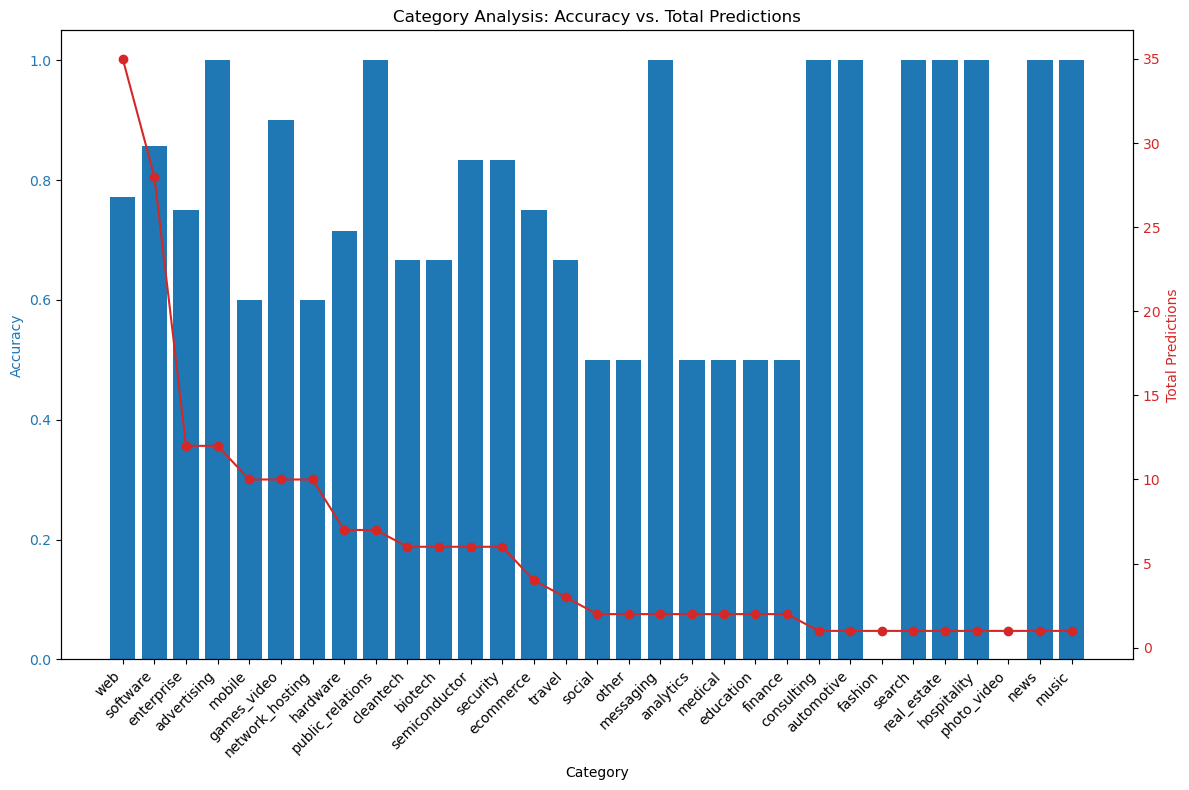

In [30]:
import matplotlib.pyplot as plt

# Calculate the total predictions for each category and the correct prediction rate
category_analysis = {}

for column in result_df.columns:
    if column.startswith('category_code_'):
        total = result_df[column].sum()  # total instances of this category
        correct = result_df[result_df['predicted_correctly'] == 1][column].sum()
        accuracy = correct / total if total > 0 else 0
        incorrect = total - correct
        category_name = column.replace('category_code_', '')
        category_analysis[category_name] = {'Total': total, 'Correct': correct, 'Incorrect': incorrect, 'Accuracy': accuracy}

# Convert to DataFrame for better visualization
category_df = pd.DataFrame.from_dict(category_analysis, orient='index')
category_df = category_df.sort_values(by='Total', ascending=False)

# Filter out categories with total prediction count of 0
category_df = category_df[category_df['Total'] > 0]

print(category_df)

# Plot the accuracy with quantitative information
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Category')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(category_df.index, category_df['Accuracy'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45, ha='right')

# Create a second y-axis for the total counts
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Predictions', color=color)
ax2.plot(category_df.index, category_df['Total'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Category Analysis: Accuracy vs. Total Predictions')
fig.tight_layout()
plt.show()


## The classifier Performance on different categories

                  Total  Correct  Incorrect
web                35.0     27.0        8.0
software           28.0     24.0        4.0
enterprise         12.0      9.0        3.0
advertising        12.0     12.0        0.0
mobile             10.0      6.0        4.0
games_video        10.0      9.0        1.0
network_hosting    10.0      6.0        4.0
hardware            7.0      5.0        2.0
public_relations    7.0      7.0        0.0
cleantech           6.0      4.0        2.0
biotech             6.0      4.0        2.0
semiconductor       6.0      5.0        1.0
security            6.0      5.0        1.0


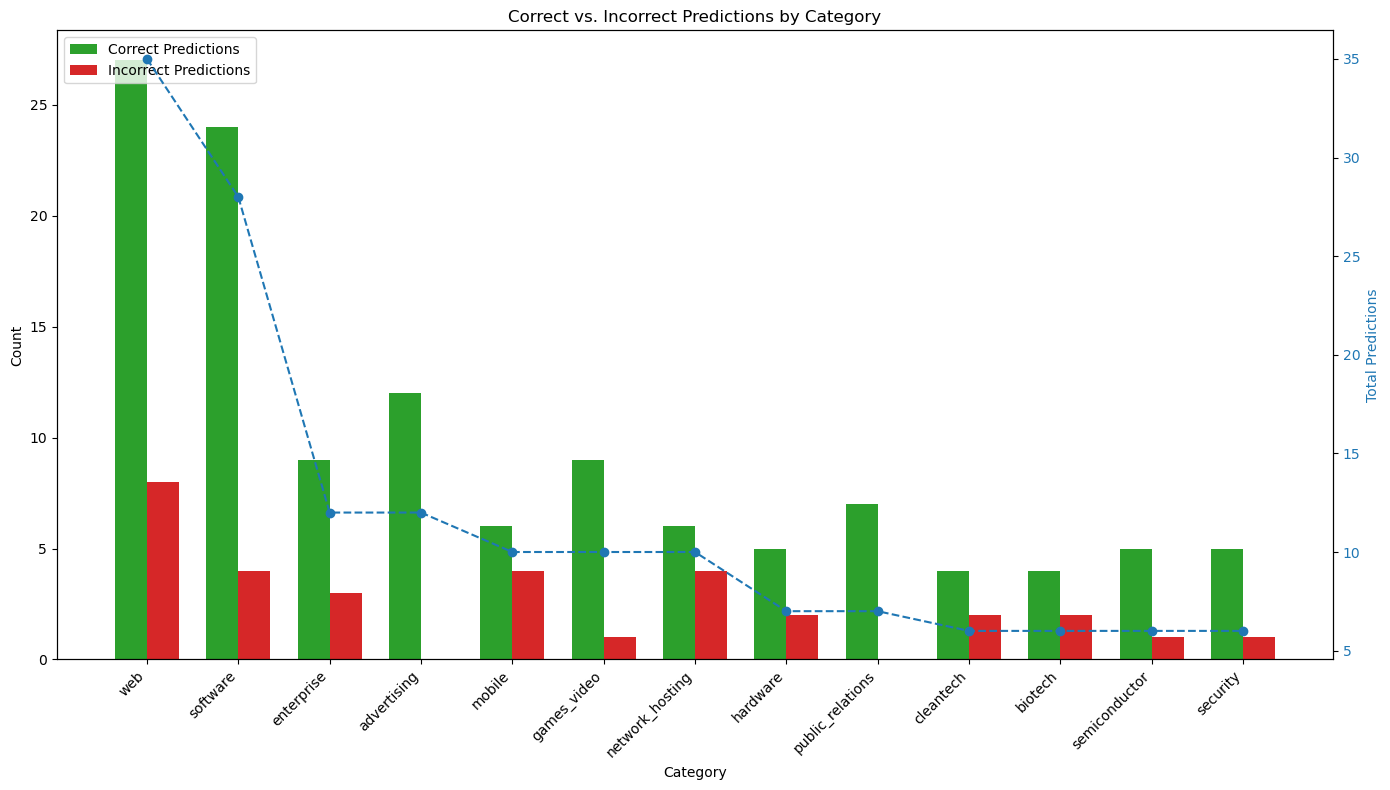

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the total predictions for each category and the correct/incorrect prediction counts
category_analysis = {}

for column in result_df.columns:
    if column.startswith('category_code_'):
        total = result_df[column].sum()  # total instances of this category
        correct = result_df[result_df['predicted_correctly'] == 1][column].sum()
        incorrect = total - correct
        category_name = column.replace('category_code_', '')
        category_analysis[category_name] = {'Total': total, 'Correct': correct, 'Incorrect': incorrect}

# Convert to DataFrame for better visualization
category_df = pd.DataFrame.from_dict(category_analysis, orient='index')
category_df = category_df.sort_values(by='Total', ascending=False)

# Filter out categories with total prediction count <5
category_df = category_df[category_df['Total'] > 5]

print(category_df)

# Plot the correct and incorrect predictions side by side with a secondary y-axis for total predictions
fig, ax1 = plt.subplots(figsize=(14, 8))

bar_width = 0.35
index = np.arange(len(category_df.index))

# Bars for correct predictions
bars1 = ax1.bar(index, category_df['Correct'], bar_width, label='Correct Predictions', color='tab:green')

# Bars for incorrect predictions
bars2 = ax1.bar(index + bar_width, category_df['Incorrect'], bar_width, label='Incorrect Predictions', color='tab:red')

# Primary y-axis
ax1.set_xlabel('Category')
ax1.set_ylabel('Count')
ax1.set_title('Correct vs. Incorrect Predictions by Category')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(category_df.index, rotation=45, ha='right')
ax1.legend(loc='upper left')

# Secondary y-axis for total predictions
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Total Predictions', color=color)
ax2.plot(index + bar_width / 2, category_df['Total'], color=color, marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout()
plt.show()


### same for 5-fold results aggregation

/tmp/ipykernel_57599/3201386085.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted'] = ensemble_pred
/tmp/ipykernel_57599/3201386085.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted'] = ensemble_pred
/tmp/ipykernel_57599/3201386085.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

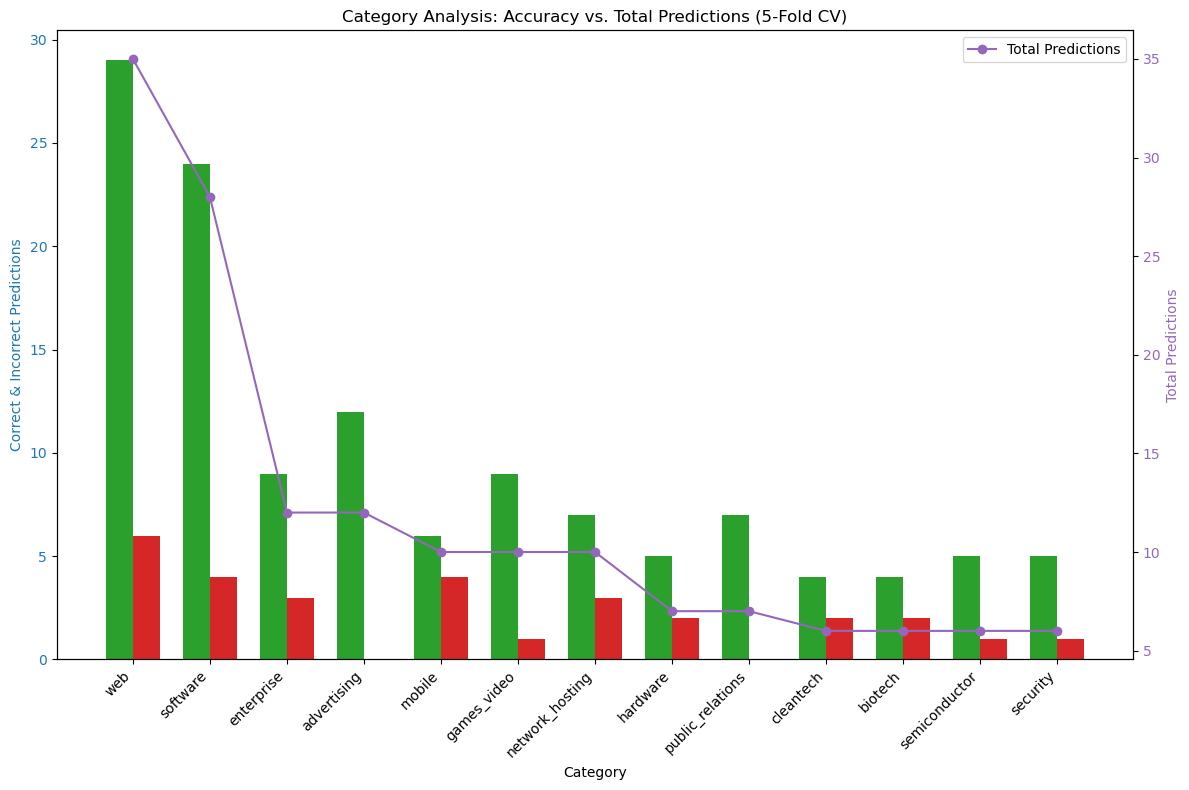

In [32]:
from sklearn.model_selection import KFold
from scipy.stats import mode

# Assuming your result_df has the necessary columns to be used as features
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

category_analysis_cv = []

for train_index, test_index in kf.split(result_df):
    train_df, test_df = result_df.iloc[train_index], result_df.iloc[test_index]

    # Ensure only the original feature columns are used
    feature_columns = X.columns  # Assuming `X` contains the original feature columns

    X_train, y_train = train_df[feature_columns], train_df['Actual']
    X_test, y_test = test_df[feature_columns], test_df['Actual']

    # Replace this with your actual model fitting and predicting code
    xgb_pred, xgb_prob = predict_model(xgb_clf, X_test)
    rfv2_pred, rfv2_prob = predict_model(rfv2_clf, X_test)
    svm_pred, svm_prob = predict_model(svm_clf, X_test)

    # Stack the predictions into a matrix
    predictions = np.vstack((xgb_pred, rfv2_pred, svm_pred)).T

    # Majority voting
    ensemble_pred, _ = mode(predictions, axis=1)
    ensemble_pred = ensemble_pred.ravel()

    # Store the predicted and actual values in test_df
    test_df['Predicted'] = ensemble_pred

    # Now calculate the statistics for this fold
    for column in result_df.columns:
        if column.startswith('category_code_'):
            total = test_df[column].sum()  # total instances of this category in the fold
            correct = test_df[(test_df['Predicted'] == test_df['Actual'])][column].sum()
            incorrect = total - correct
            accuracy = correct / total if total > 0 else 0
            category_name = column.replace('category_code_', '')
            category_analysis_cv.append({'Category': category_name, 'Total': total, 'Correct': correct, 'Incorrect': incorrect, 'Accuracy': accuracy})

# Aggregate results across folds
category_df_cv = pd.DataFrame(category_analysis_cv)
category_df_cv = category_df_cv.groupby('Category').sum()
category_df_cv['Accuracy'] = category_df_cv['Correct'] / category_df_cv['Total']

# Sort by the most common categories
category_df_cv = category_df_cv.sort_values(by='Total', ascending=False)

# Filter out categories with total prediction count of <5
category_df_cv = category_df_cv[category_df_cv['Total'] > 5]

# Set the width for the bars
bar_width = 0.35

# Plotting Correct vs Incorrect predictions side by side
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Category')
ax1.set_ylabel('Correct & Incorrect Predictions', color=color)

# Set the positions for the bars
index = np.arange(len(category_df_cv))

# Plot the bars side by side
ax1.bar(index - bar_width/2, category_df_cv['Correct'], bar_width, color='tab:green', label='Correct')
ax1.bar(index + bar_width/2, category_df_cv['Incorrect'], bar_width, color='tab:red', label='Incorrect')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(index)
ax1.set_xticklabels(category_df_cv.index, rotation=45, ha='right')

# Create a second y-axis for the total counts
ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Total Predictions', color=color)
ax2.plot(index, category_df_cv['Total'], color=color, marker='o', label='Total Predictions')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Category Analysis: Accuracy vs. Total Predictions (5-Fold CV)')
fig.tight_layout()
plt.legend()
plt.show()


# # Plotting Correct vs Incorrect predictions along with total predictions
# fig, ax1 = plt.subplots(figsize=(12, 8))

# color = 'tab:blue'
# ax1.set_xlabel('Category')
# ax1.set_ylabel('Correct & Incorrect Predictions', color=color)
# ax1.bar(category_df_cv.index, category_df_cv['Correct'], color='tab:green', label='Correct')
# ax1.bar(category_df_cv.index, category_df_cv['Incorrect'], color='tab:red', label='Incorrect', bottom=category_df_cv['Correct'])
# ax1.tick_params(axis='y', labelcolor=color)
# plt.xticks(rotation=45, ha='right')

# # Create a second y-axis for the total counts
# ax2 = ax1.twinx()
# color = 'tab:purple'
# ax2.set_ylabel('Total Predictions', color=color)
# ax2.plot(category_df_cv.index, category_df_cv['Total'], color=color, marker='o', label='Total Predictions')
# ax2.tick_params(axis='y', labelcolor=color)

# plt.title('Category Analysis: Accuracy vs. Total Predictions (5-Fold CV)')
# fig.tight_layout()
# plt.legend()
# plt.show()


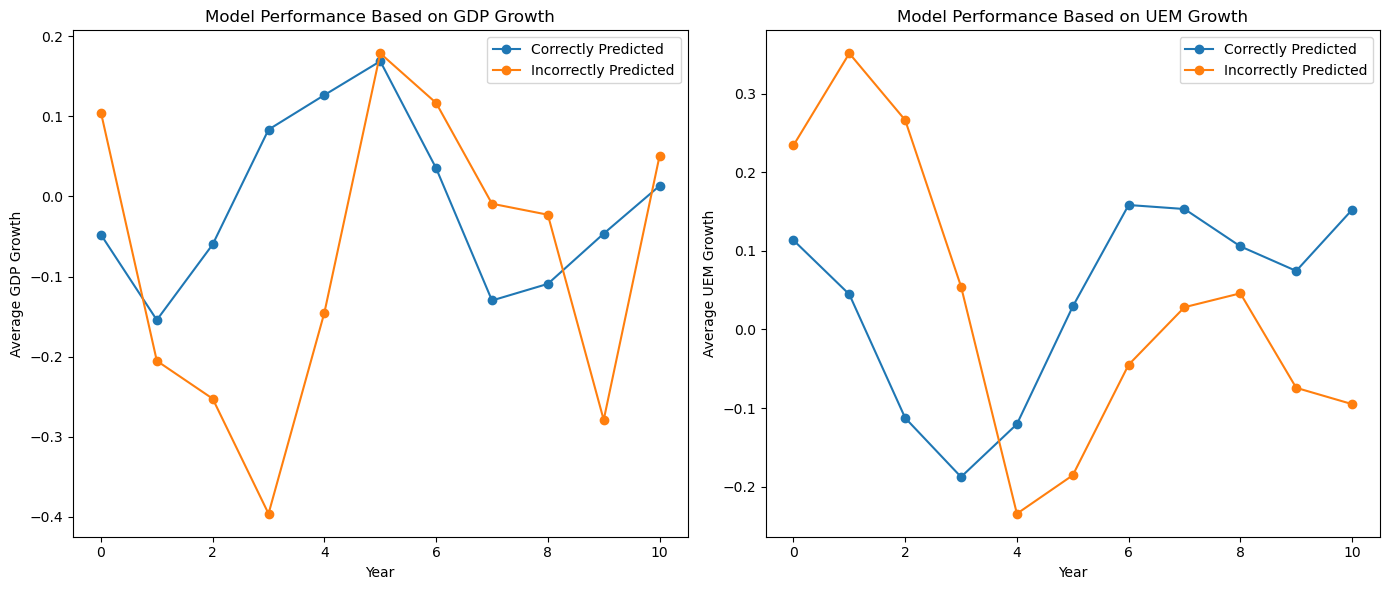

In [33]:
# Extract GDP and UEM columns
gdp_columns = [col for col in result_df.columns if 'GDP_growth_at_year' in col]
uem_columns = [col for col in result_df.columns if 'UEM_growth_at_year' in col]

# Calculate mean prediction correctness for each year
gdp_accuracy = result_df.groupby('predicted_correctly')[gdp_columns].mean().T
uem_accuracy = result_df.groupby('predicted_correctly')[uem_columns].mean().T

# Assign a vector of 0-10 to the 'Year' column
gdp_accuracy['Year'] = list(range(11))
uem_accuracy['Year'] = list(range(11))

# Plotting the results
plt.figure(figsize=(14, 6))

# GDP Growth plot
plt.subplot(1, 2, 1)
plt.plot(gdp_accuracy['Year'], gdp_accuracy[1], label='Correctly Predicted', marker='o')
plt.plot(gdp_accuracy['Year'], gdp_accuracy[0], label='Incorrectly Predicted', marker='o')
plt.xlabel('Year')
plt.ylabel('Average GDP Growth')
plt.title('Model Performance Based on GDP Growth')
plt.legend()

# UEM Growth plot
plt.subplot(1, 2, 2)
plt.plot(uem_accuracy['Year'], uem_accuracy[1], label='Correctly Predicted', marker='o')
plt.plot(uem_accuracy['Year'], uem_accuracy[0], label='Incorrectly Predicted', marker='o')
plt.xlabel('Year')
plt.ylabel('Average UEM Growth')
plt.title('Model Performance Based on UEM Growth')
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'correct_original_df' is not defined

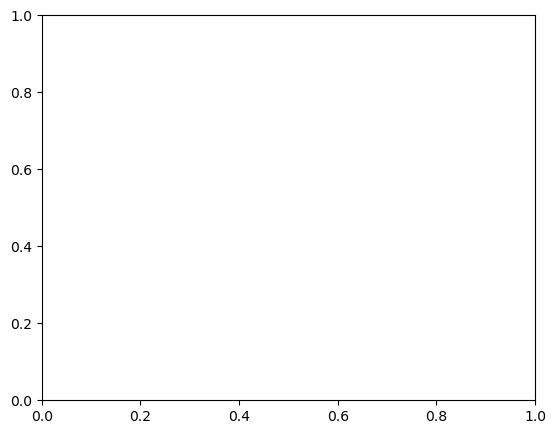

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 5))

# Plot distribution for relationships on the left
plt.subplot(1, 2, 1)
sns.kdeplot(correct_original_df['relationships'], shade=True, label='Correct', color='g')
sns.kdeplot(incorrect_original_df['relationships'], shade=True, label='Incorrect', color='r')
plt.title('Distribution of "relationships"')
plt.legend()

# Plot distribution for founded_at_year on the right
plt.subplot(1, 2, 2)
sns.kdeplot(correct_original_df['founded_at_year'], shade=True, label='Correct', color='g')
sns.kdeplot(incorrect_original_df['founded_at_year'], shade=True, label='Incorrect', color='r')
plt.title('Distribution of "founded_at_year"')
plt.legend()

# Add a big title to the entire figure
plt.suptitle('High effect Feature Distributions for Correct and Incorrect Predictions', fontsize=16, y=1.05)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
df1.category_code.value_counts()

In [ ]:
result_df_ok = result_df[result_df['Predicted_ensemble'] == result_df['Actual']]
result_df_fail = result_df[result_df['Predicted_ensemble'] != result_df['Actual']]

print(result_df_ok['category_code_biotech'].value_counts() / len(result_df_ok))

In [ ]:
print(result_df_ok.category_code_biotech.value_counts())

In [ ]:
result_df_fail.category_code_finance.value_counts()

In [ ]:
result_df_fail['category_code_biotech'] = result_df_fail.category_code_biotech.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['category_code_biotech'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_biotech'].value_counts() )

In [ ]:
result_df_fail['category_code_software'] = result_df_fail.category_code_software.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['category_code_software'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_software'].value_counts() )

In [ ]:
result_df_fail['is_othercategory'] = result_df_fail.is_othercategory.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['is_othercategory'].value_counts() / len(result_df_fail))
print(result_df_fail['is_othercategory'].value_counts() )

In [ ]:
result_df.is_othercategory.value_counts()

# Regressors

In [ ]:
'''
'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate',
'category_code', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory',
'has_roundB', 'has_roundC', 'has_roundD', 'has_VC', 'has_angel', 'has_roundA',
'''
'''
'closed_at', 'age_first_funding_year', 'age_last_funding_year',
'age_first_milestone_year', 'age_last_milestone_year', 'funding_rounds', 'funding_total_usd',
'milestones', 'avg_participants',
'''

## predict age_first_funding_year

In [ ]:
# Create target
y = df['age_first_funding_year']
df1 = df.drop('age_first_funding_year', axis=1)
# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'age_first_funding_year', tolerance = 0.4)

accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Custom Accuracy within {1} year: {accuracy_abs * 100:.2f}%")

## age_last_funding_year

In [ ]:
# Create target
y = df['age_last_funding_year']
df1 = df.drop('age_last_funding_year', axis=1)
# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'age_last_funding_year', tolerance = 0.3)
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} year: {accuracy_abs * 100:.2f}%")

## funding_rounds

In [ ]:
# Create target
df1 = df.copy()

# Drop rows where 'age_first_milestone_year' is NaN
df1.dropna(subset=['age_first_milestone_year'], inplace=True)
print(len(df1))
y = df1['age_first_milestone_year']
df1 = df1.drop('age_first_milestone_year', axis=1)
# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'age_first_milestone_year', tolerance = 0.3)
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} round: {accuracy_abs * 100:.2f}%")

## funding_total_usd

In [ ]:
# Preprocess and split the data train and evaluate:
X = preprocess_data(df, useKNNImputer=True)
y = df['funding_total_usd'] # Create target
X = X.drop('funding_total_usd', axis=1)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'funding_total_usd', tolerance = 0.4)
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} mln usd: {accuracy_abs * 100:.2f}%")

## milestones

In [ ]:
# Create target
y = df['milestones']
df1 = df.copy()
df1 = df1.drop('milestones', axis=1)

# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'milestones')
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} mln usd: {accuracy_abs * 100:.2f}%")

In [ ]:
'age_first_funding_year', 'age_last_funding_year',
'age_first_milestone_year', 'age_last_milestone_year', 'funding_rounds', 'funding_total_usd',
'milestones'